# Import Libraries

In [102]:
import warnings
warnings.filterwarnings('ignore')

import functions as fn

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import cufflinks as cf
from pandas_profiling import ProfileReport

pd.options.display.float_format = '{:.4f}'.format
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

In [2]:
startDate = '1992-01-01'

In [3]:
def formatDates(data, position):
    dates = []
    for index, row in data.iterrows():
        dates.append(str(row[position])[:8] + '01')
    return dates

def resampleMonthly(data, dateColumn, dateLocation, on, method):
    df = data.resample('M', on=on).mean().interpolate(method=method)
    df.reset_index(inplace=True)
    df[dateColumn] = formatDates(df, dateLocation)
    df[dateColumn] = pd.to_datetime(df[dateColumn])
    df.sort_values(dateColumn, inplace=True)
    df.set_index(dateColumn,inplace=True)
    return df

# All EU Dataset

In [4]:
EUdata = pd.read_csv('data/apro_mt_pwgtm_1_Data.csv')
EUdata = EUdata[EUdata['UNIT'] == 'Thousand tonnes']
EUdata = EUdata[['TIME', 'GEO', 'MEAT', 'Value']]
EUdata.columns = ['Date', 'Country', 'Meat', 'Value']
#EUdata = EUdata[(EUdata.Meat == 'Bovine meat') | (EUdata.Meat == 'Pigmeat')]
#EUdata = EUdata[EUdata.Meat == 'Bovine meat']

EUdata.Date = pd.to_datetime(EUdata.Date, format='%YM%m')
EUdata = EUdata[EUdata.Date >= startDate]

EUdata['Country'] = EUdata['Country'].str.slice(0,7)
EUdata = EUdata.replace([':'], 0, regex=True)
EUdata['Value'] = EUdata['Value'].astype(float)

EUdata.reset_index(inplace=True, drop=True)

EUdata

,Date,Country,Meat,Value
0,1992-01-01,Germany,Bovine meat,159.1700
1,1992-01-01,Germany,Pigmeat,323.2400
2,1992-01-01,Germany,Sheepmeat,2.9100
3,1992-01-01,Germany,Poultry meat,0.0000
4,1992-01-01,Ireland,Bovine meat,35.0000
...,...,...,...,...
2899,2022-03-01,Germany,Poultry meat,0.0000
2900,2022-03-01,Ireland,Bovine meat,53.3500
2901,2022-03-01,Ireland,Pigmeat,30.8300
2902,2022-03-01,Ireland,Sheepmeat,5.6400


In [5]:
EUdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2904 entries, 0 to 2903
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     2904 non-null   datetime64[ns]
 1   Country  2904 non-null   object        
 2   Meat     2904 non-null   object        
 3   Value    2904 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 90.9+ KB


# Ireland Slaughter Data

In [6]:
irelandData = EUdata[EUdata['Country'] == 'Ireland'].reset_index(drop=True)
irelandData = irelandData[irelandData.Meat != 'Poultry meat']
irelandData = irelandData.pivot_table(index='Date', columns='Meat', values='Value')
irelandData.reset_index(inplace=True)
irelandData.set_index('Date',inplace=True)
irelandData.columns = ['Ireland Bovine Meat', 'Ireland Pig Meat', 'Ireland Lamb Meat']
irelandData

,Ireland Bovine Meat,Ireland Pig Meat,Ireland Lamb Meat
Date,,,
1992-01-01,35.0000,17.9000,6.5000
1992-02-01,31.9000,15.0000,5.3000
1992-03-01,46.7000,16.5000,4.7000
1992-04-01,40.0000,16.0000,5.9000
1992-05-01,33.8000,15.9000,7.9000
...,...,...,...
2021-11-01,56.1500,31.4800,5.8600
2021-12-01,45.5800,27.0300,5.6800
2022-01-01,47.3600,28.0100,5.0300


## Ireland Data NaN Count

In [7]:
irelandData.isna().sum()

Ireland Bovine Meat    0
Ireland Pig Meat       0
Ireland Lamb Meat      0
dtype: int64

## Ireland Data Box Plot

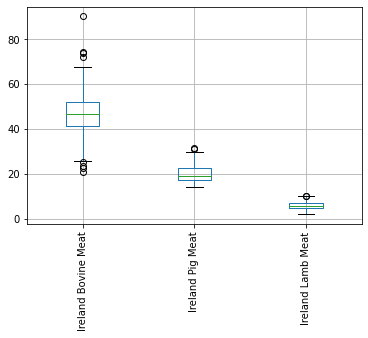

In [8]:
irelandData.boxplot(rot=90);

In [9]:
#https://plotly.com/python/box-plots/
fig = px.box(irelandData)
fig.show()

In [10]:
fig = px.box(irelandData, points='all')
fig.show()

## Ireland Slaughter Plot

In [11]:
fig = px.line(irelandData, labels={'value': 'Tonne in thousands',
                    'Month':'Date'})
fig.update_layout(title_text='Livestock Slaughterings Ireland', 
                  title_x=0.5, legend_title='Livestock')
fig.show()

## Ireland Slaughter Growth Plot

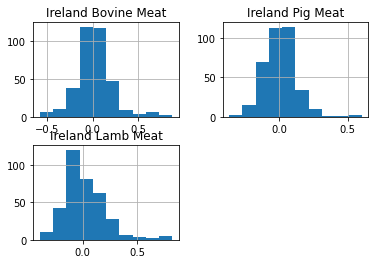

In [12]:
irelandData[['Ireland Bovine Meat', 'Ireland Pig Meat', 'Ireland Lamb Meat']].pct_change().hist();

In [13]:
fig = px.line(irelandData[['Ireland Bovine Meat', 'Ireland Pig Meat', 
                           'Ireland Lamb Meat']].pct_change(), 
              labels={'value': 'Tonne in thousands',
                    'Month':'Date'})
fig.update_layout(title_text='Livestock Slaughterings Ireland', 
                  title_x=0.5, legend_title='Livestock')
fig.show()

In [14]:
fig = px.line(irelandData.pct_change().cumsum(),
             labels={'value': 'Percentage Growth',
                    'Month':'Date'})
fig.update_layout(title_text='Livestock Slaughterings Growth Ireland', 
                  title_x=0.5, legend_title='Livestock')
fig.show()

# Germany Slaughter Data

In [15]:
germanData = EUdata[EUdata['Country'] == 'Germany'].reset_index(drop=True)
germanData = germanData[germanData.Meat != 'Poultry meat']
germanData = germanData.pivot_table(index='Date', columns='Meat', values='Value')
germanData.reset_index(inplace=True)
germanData.set_index('Date',inplace=True)
germanData.columns = ['Germany Bovine Meat', 'Germany Pig Meat', 'Germany Lamb Meat']
germanData

,Germany Bovine Meat,Germany Pig Meat,Germany Lamb Meat
Date,,,
1992-01-01,159.1700,323.2400,2.9100
1992-02-01,140.1100,285.4000,2.5200
1992-03-01,164.5400,316.9800,3.1600
1992-04-01,155.6100,297.4600,3.6500
1992-05-01,144.8200,300.1500,2.7000
...,...,...,...
2021-11-01,104.0000,421.0000,2.0000
2021-12-01,91.0000,413.0000,2.0000
2022-01-01,77.0000,384.0000,2.0000


## Germany NaN Count

In [16]:
germanData.isna().sum()

Germany Bovine Meat    0
Germany Pig Meat       0
Germany Lamb Meat      0
dtype: int64

## Germany Data Box Plot

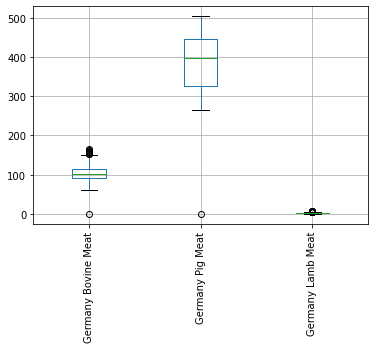

In [17]:
germanData.boxplot(rot=90);

In [18]:
#https://plotly.com/python/box-plots/
fig = px.box(germanData)
fig.show()

In [19]:
fig = px.box(germanData, points='all')
fig.show()

## Germany Slaughter Plot

In [20]:
fig = px.line(germanData, labels={'value': 'Tonne in thousands',
                    'Month':'Date'})
fig.update_layout(title_text='Livestock Slaughterings Germany', 
                  title_x=0.5, legend_title='Livestock')
fig.show()

## Germany Slaughter Growth Plot

In [21]:
fig = px.line(germanData.pct_change().cumsum(),
             labels={'value': 'Percentage Growth',
                    'Month':'Date'})
fig.update_layout(title_text='Livestock Slaughterings Growth Germany', 
                  title_x=0.5, legend_title='Livestock')
fig.show()

# USA Slaughter Data

In [22]:
usaData = pd.read_excel('data/MeatStatsFullUSA.xlsx', sheet_name='SlaughterWeights-Full',
                   skiprows=2)
dates = usaData.iloc[:,0]

usaData = usaData.iloc[:, 13:]
usaData.insert(loc=0, column='Date', value=dates)
usaData.drop(usaData.head(2).index, inplace=True)
usaData.drop(usaData.tail(6).index, inplace=True)
usaData.Date = pd.to_datetime(usaData.Date, format='%b-%Y')
usaData = usaData[usaData.Date >= startDate].reset_index(drop=True)
usaData.index = usaData.Date
usaData.drop(columns='Date', inplace=True)

usaData['USA Bovine Meat'] = usaData['Cattle.2'] + usaData['Calves.2']
usaData['USA Pig Meat'] = usaData['Hogs.2']
usaData['USA Sheep Meat'] = usaData['Sheep and lambs.2']
usaData = usaData[['USA Bovine Meat', 'USA Pig Meat', 'USA Sheep Meat']]
usaData

,USA Bovine Meat,USA Pig Meat,USA Sheep Meat
Date,,,
2022-03-01,987.0000,218.0000,68.0000
2022-02-01,981.0000,218.0000,67.0000
2022-01-01,985.0000,219.0000,66.0000
2021-12-01,977.0000,218.0000,64.0000
2021-11-01,976.0000,216.0000,64.0000
...,...,...,...
1992-05-01,934.0000,183.0000,65.0000
1992-04-01,928.0000,182.0000,64.0000
1992-03-01,927.0000,181.0000,66.0000


In [23]:
#https://plotly.com/python/box-plots/
fig = px.box(usaData)
fig.show()

## Convert USA Data to Tonne

In [24]:
#usaData = (usaData * 1000) / 2204.6 
usaData = usaData / 0.453592
usaData

,USA Bovine Meat,USA Pig Meat,USA Sheep Meat
Date,,,
2022-03-01,2175.9643,480.6081,149.9145
2022-02-01,2162.7366,480.6081,147.7098
2022-01-01,2171.5551,482.8127,145.5052
2021-12-01,2153.9181,480.6081,141.0960
2021-11-01,2151.7134,476.1989,141.0960
...,...,...,...
1992-05-01,2059.1192,403.4463,143.3006
1992-04-01,2045.8915,401.2416,141.0960
1992-03-01,2043.6868,399.0370,145.5052


## USA Slaughter Plot

In [25]:
fig = px.line(usaData, labels={'value': 'Tonne in thousands',
                    'Month':'Date'})
fig.update_layout(title_text='Livestock Slaughterings USA', 
                  title_x=0.5, legend_title='Livestock')
fig.show()

## USA Slaughter Growth Plot

In [26]:
fig = px.line(usaData.pct_change().cumsum(),
             labels={'value': 'Percentage Growth',
                    'Month':'Date'})
fig.update_layout(title_text='Livestock Slaughterings Growth USA', 
                  title_x=0.5, legend_title='Livestock')
fig.show()

# Economic Data Import

## Population Data

### Ireland Population Data

In [27]:
irelandPop = pd.read_csv('data/POPTOTIEA647NWDB.csv', 
                         parse_dates=['DATE'])
irelandPop.columns = ['Date','Ireland Population']
irelandPop = irelandPop[irelandPop.Date >= startDate]

irelandPop = resampleMonthly(irelandPop, 'Date', 0, 'Date', 'linear')

### Germany Population Data

In [28]:
germanyPop = pd.read_csv('data/POPTOTDEA647NWDB.csv',
                    parse_dates=['DATE'])
germanyPop.columns = ['Date','German Population']
germanyPop = germanyPop[germanyPop.Date >= startDate]
germanyPop = resampleMonthly(germanyPop, 'Date', 0, 'Date', 'linear')
germanyPop

,German Population
Date,
1992-01-01,80624598.0000
1992-02-01,80668911.7500
1992-03-01,80713225.5000
1992-04-01,80757539.2500
1992-05-01,80801853.0000
...,...
2019-09-01,83191337.3333
2019-10-01,83203634.2500
2019-11-01,83215931.1667


### USA Population Data

In [29]:
usaPop = pd.read_csv('data/POPTOTUSA647NWDB.csv',
                    parse_dates=['DATE'])
usaPop.columns = ['Date','USA Population']
usaPop = usaPop[usaPop.Date >= startDate]
usaPop = resampleMonthly(usaPop, 'Date', 0, 'Date', 'linear')

## GDP

In [30]:
ecoData = pd.read_csv('data/worldBankData.csv', skiprows=4)
ecoData = ecoData[(ecoData['Indicator Name'] == 'GDP (constant LCU)') |
                 (ecoData['Indicator Name'] == 'GDP per capita (current LCU)')].reset_index(drop=True)
ecoData = ecoData.melt(id_vars=['Country Name', 'Indicator Name', 'Indicator Code', 'Country Code'],
                   var_name='Year', value_name='Total')
ecoData.Year = pd.to_datetime(ecoData.Year)
ecoData = ecoData[ecoData.Year >= startDate].reset_index(drop=True)
ecoData = ecoData[['Country Name', 'Indicator Name', 'Year', 'Total']]
ecoData

,Country Name,Indicator Name,Year,Total
0,Germany,GDP per capita (current LCU),1992-01-01,21110.9270
1,Germany,GDP (constant LCU),1992-01-01,2261460000000.0000
2,Ireland,GDP per capita (current LCU),1992-01-01,11727.6453
3,Ireland,GDP (constant LCU),1992-01-01,76486482000.0000
4,United States,GDP per capita (current LCU),1992-01-01,25418.9908
...,...,...,...,...
175,Germany,GDP (constant LCU),2021-01-01,NaN
176,Ireland,GDP per capita (current LCU),2021-01-01,NaN
177,Ireland,GDP (constant LCU),2021-01-01,NaN
178,United States,GDP per capita (current LCU),2021-01-01,NaN


### Ireland GDP

In [31]:
irelandGDP = ecoData[ecoData['Country Name'] == 'Ireland']
irelandGDP = irelandGDP.pivot_table(index='Year', columns='Indicator Name', values='Total')
irelandGDP.columns = ['Ireland GDP', 'Ireland GDP Per Capita']
irelandGDP.reset_index(inplace=True)

irelandGDP = resampleMonthly(irelandGDP, 'Year', 0, 'Year', 'linear')
irelandGDP

,Ireland GDP,Ireland GDP Per Capita
Year,,
1992-01-01,76486482000.0000,11727.6453
1992-02-01,76658105500.0000,11800.6422
1992-03-01,76829729000.0000,11873.6390
1992-04-01,77001352500.0000,11946.6358
1992-05-01,77172976000.0000,12019.6326
...,...,...
2019-09-01,347254666666.6667,73943.3529
2019-10-01,348888500000.0000,74154.5104
2019-11-01,350522333333.3333,74365.6678


### Germany GDP

In [32]:
germanyGDP = ecoData[ecoData['Country Name'] == 'Germany']
germanyGDP = germanyGDP.pivot_table(index='Year', columns='Indicator Name', values='Total')
germanyGDP.columns = ['Germany GDP', 'Germany GDP Per Capita']
germanyGDP.reset_index(inplace=True)

germanyGDP = resampleMonthly(germanyGDP, 'Year', 0, 'Year', 'linear')
germanyGDP

,Germany GDP,Germany GDP Per Capita
Year,,
1992-01-01,2261460000000.0000,21110.9270
1992-02-01,2259619166666.6665,21149.5396
1992-03-01,2257778333333.3335,21188.1523
1992-04-01,2255937500000.0000,21226.7649
1992-05-01,2254096666666.6665,21265.3776
...,...,...
2019-09-01,3146116666666.6665,40929.9411
2019-10-01,3133760000000.0000,40821.0871
2019-11-01,3121403333333.3335,40712.2332


### USA GDP

In [33]:
usaGDP = ecoData[ecoData['Country Name'] == 'United States']
usaGDP = usaGDP.pivot_table(index='Year', columns='Indicator Name', values='Total')
usaGDP.columns = ['USA GDP', 'USA GDP Per Capita']
usaGDP.reset_index(inplace=True)

usaGDP = resampleMonthly(usaGDP, 'Year', 0, 'Year', 'linear')
usaGDP

,USA GDP,USA GDP Per Capita
Year,,
1992-01-01,10139200000000.0000,25418.9908
1992-02-01,10162450000000.0000,25499.6827
1992-03-01,10185700000000.0000,25580.3746
1992-04-01,10208950000000.0000,25661.0665
1992-05-01,10232200000000.0000,25741.7584
...,...,...
2019-09-01,19521166666666.6680,63897.5237
2019-10-01,19464500000000.0000,63724.7731
2019-11-01,19407833333333.3320,63552.0224


## Trade

In [34]:
trade = pd.read_csv('data/FAOSTAT_data_5-6-2022ImportsExports.csv')
trade = trade[['Area', 'Element', 'Item','Year','Unit', 'Value']]
trade = trade[(trade.Item == 'Meat, cattle') & (trade.Unit == 'tonnes')]

### Ireland Trade

In [35]:
irelandTrade = trade[trade.Area == 'Ireland']
irelandTrade = irelandTrade.pivot_table(index='Year', columns='Element', values='Value')
irelandTrade['Ireland Surplus'] = irelandTrade['Export Quantity'] - irelandTrade['Import Quantity']
irelandTrade.reset_index(inplace=True)
irelandTrade.Year = pd.to_datetime(irelandTrade.Year, format='%Y')
irelandTrade = resampleMonthly(irelandTrade, 'Year', 0, 'Year', 'linear')

### Germany Trade

In [36]:
germanyTrade = trade[trade.Area == 'Germany']
germanyTrade = germanyTrade.pivot_table(index='Year', columns='Element', values='Value')
germanyTrade['Germany Surplus'] = germanyTrade['Export Quantity'] - germanyTrade['Import Quantity']
germanyTrade = germanyTrade[['Germany Surplus']]
germanyTrade.reset_index(inplace=True)
germanyTrade.Year = pd.to_datetime(germanyTrade.Year, format='%Y')

germanyTrade = resampleMonthly(germanyTrade, 'Year', 0, 'Year', 'linear')

### USA Trade

In [37]:
usaTrade = trade[trade.Area == 'United States of America']
usaTrade = usaTrade.pivot_table(index='Year', columns='Element', values='Value')
usaTrade['USA Surplus'] = usaTrade['Export Quantity'] - usaTrade['Import Quantity']
usaTrade = usaTrade[['USA Surplus']]
usaTrade.reset_index(inplace=True)
usaTrade.Year = pd.to_datetime(usaTrade.Year, format='%Y')

usaTrade = resampleMonthly(usaTrade, 'Year', 0, 'Year', 'linear')

## Prices

In [38]:
prices = pd.read_csv('data/globalBeefPricesFred.csv')
prices.columns = ['Date','Price']
prices.Date = pd.to_datetime(prices.Date)
prices['Price'] = prices['Price'] / 0.453592
prices = resampleMonthly(prices, 'Date', 0, 'Date', 'linear')
prices

,Price
Date,
1990-01-01,257.5295
1990-02-01,254.5312
1990-03-01,251.5329
1990-04-01,248.5346
1990-05-01,253.5783
...,...
2021-03-01,497.3874
2021-04-01,523.0456
2021-05-01,530.4728


## Land Productivity

In [39]:
df = pd.read_csv('data/FAOSTAT_data_Land_Use_Per_Meat.csv')
df = df[['Area', 'Element', 'Year','Item', 'Unit','Value']]
df = df[df.Unit == 'hg/An']
df.Year = pd.to_datetime(df.Year, format='%Y')
df = df[df.Year >= startDate].reset_index(drop=True)
beefProduction = df[df.Item == 'Meat, cattle']
beefProduction

,Area,Element,Year,Item,Unit,Value
0,Germany,Yield/Carcass Weight,1992-01-01,"Meat, cattle",hg/An,2905
1,Germany,Yield/Carcass Weight,1993-01-01,"Meat, cattle",hg/An,2948
2,Germany,Yield/Carcass Weight,1994-01-01,"Meat, cattle",hg/An,2932
3,Germany,Yield/Carcass Weight,1995-01-01,"Meat, cattle",hg/An,2962
4,Germany,Yield/Carcass Weight,1996-01-01,"Meat, cattle",hg/An,2973
5,Germany,Yield/Carcass Weight,1997-01-01,"Meat, cattle",hg/An,2922
6,Germany,Yield/Carcass Weight,1998-01-01,"Meat, cattle",hg/An,2965
7,Germany,Yield/Carcass Weight,1999-01-01,"Meat, cattle",hg/An,3012
8,Germany,Yield/Carcass Weight,2000-01-01,"Meat, cattle",hg/An,3041
9,Germany,Yield/Carcass Weight,2001-01-01,"Meat, cattle",hg/An,3125


### Ireland Land Yield

In [40]:
irelandLand = beefProduction[beefProduction.Area == 'Ireland']
irelandLand = irelandLand[['Year', 'Value']].reset_index(drop=True)
irelandLand = resampleMonthly(irelandLand, 'Year', 0, 'Year', 'linear')
irelandLand.columns = ['Ireland Land Yield']

### Germany Land Yield

In [41]:
germanyLand = beefProduction[beefProduction.Area == 'Germany']
germanyLand = germanyLand[['Year', 'Value']].reset_index(drop=True)
germanyLand = resampleMonthly(germanyLand, 'Year', 0, 'Year', 'linear')
germanyLand.columns = ['Germany Land Yield']

### USA Land Yield

In [42]:
usaLand = beefProduction[beefProduction.Area == 'United States of America']
usaLand = usaLand[['Year', 'Value']].reset_index(drop=True)
usaLand = resampleMonthly(usaLand, 'Year', 0, 'Year', 'linear')
usaLand.columns = ['USA Land Yield']

# Merge Datasets

## Bovine Meat Production

In [43]:
allData = pd.concat([irelandData, usaData, germanData], axis=1)
allData.dropna(inplace=True)
allData

,Ireland Bovine Meat,Ireland Pig Meat,Ireland Lamb Meat,USA Bovine Meat,USA Pig Meat,USA Sheep Meat,Germany Bovine Meat,Germany Pig Meat,Germany Lamb Meat
Date,,,,,,,,,
1992-01-01,35.0000,17.9000,6.5000,2030.4591,403.4463,143.3006,159.1700,323.2400,2.9100
1992-02-01,31.9000,15.0000,5.3000,2048.0961,401.2416,143.3006,140.1100,285.4000,2.5200
1992-03-01,46.7000,16.5000,4.7000,2043.6868,399.0370,145.5052,164.5400,316.9800,3.1600
1992-04-01,40.0000,16.0000,5.9000,2045.8915,401.2416,141.0960,155.6100,297.4600,3.6500
1992-05-01,33.8000,15.9000,7.9000,2059.1192,403.4463,143.3006,144.8200,300.1500,2.7000
...,...,...,...,...,...,...,...,...,...
2021-11-01,56.1500,31.4800,5.8600,2151.7134,476.1989,141.0960,104.0000,421.0000,2.0000
2021-12-01,45.5800,27.0300,5.6800,2153.9181,480.6081,141.0960,91.0000,413.0000,2.0000
2022-01-01,47.3600,28.0100,5.0300,2171.5551,482.8127,145.5052,77.0000,384.0000,2.0000


In [44]:
fig = px.line(allData,
             labels={'value': 'Tonne in thousands',
                    'Month':'Date'})
fig.update_layout(title_text='Livestock Slaughterings Growth Ireland USA & Germany', 
                  title_x=0.5, legend_title='Livestock')
fig.show()

## All Data Growth Plot

In [45]:
fig = px.line(allData.pct_change().cumsum(),
             labels={'value': 'Percentage Growth',
                    'Month':'Date'})
fig.update_layout(title_text='Livestock Slaughterings Growth Ireland, USA & Germany', 
                  title_x=0.5, legend_title='Livestock')
fig.show()

## Population Data

In [46]:
allPopulationData = pd.concat([irelandPop, usaPop, germanyPop], axis=1)
allPopulationData

,Ireland Population,USA Population,German Population
Date,,,
1992-01-01,3558430.0000,256514000.0000,80624598.0000
1992-02-01,3559915.9167,256797750.0000,80668911.7500
1992-03-01,3561401.8333,257081500.0000,80713225.5000
1992-04-01,3562887.7500,257365250.0000,80757539.2500
1992-05-01,3564373.6667,257649000.0000,80801853.0000
...,...,...,...
2019-09-01,4974596.0000,329099399.6667,83191337.3333
2019-10-01,4979628.0000,329195580.5000,83203634.2500
2019-11-01,4984660.0000,329291761.3333,83215931.1667


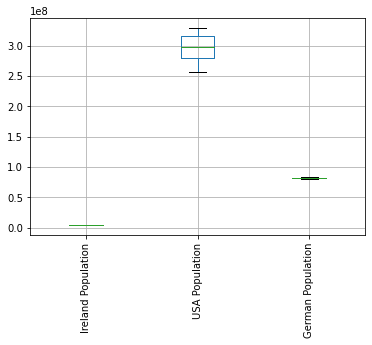

In [47]:
allPopulationData.boxplot(rot=90);

In [48]:
fig = px.line(allPopulationData[['Ireland Population', 'USA Population', 'German Population']].pct_change().cumsum(),
             labels={'value': 'Percentage Population Growth',
                    'Date':'Date'})
fig.update_layout(title_text='Population Percentage Growth Ireland, Germany & USA', 
                  title_x=0.5, legend_title='Population')
fig.show()

## Production Per Capita

In [49]:
bovineMeat = allData.copy()
bovineMeat.drop(bovineMeat.tail(len(allData) - len(irelandPop)).index, inplace=True)

bovineMeatData = pd.DataFrame()
bovineMeatData['Ireland Per Capita Bovine Meat Production'] = bovineMeat['Ireland Bovine Meat'].values / irelandPop['Ireland Population'].values * 1000000
bovineMeatData['USA Per Capita Bovine Meat Production'] = bovineMeat['USA Bovine Meat'].values / usaPop['USA Population'].values * 1000000
bovineMeatData['Germany Per Capita Bovine Meat Production'] = bovineMeat['Germany Bovine Meat'].values / germanyPop['German Population'].values * 1000000

In [50]:
fig = px.line(bovineMeatData.pct_change().cumsum(),
             labels={'value': 'Percentage Cattle Slaughter Growth',
                    'Date':'Date'})
fig.update_layout(title_text='Bovine Meat Percentage Growth Per Capita in Ireland, Germany & USA', 
                  title_x=0.5, legend_title='Per Capita Production')
fig.show()

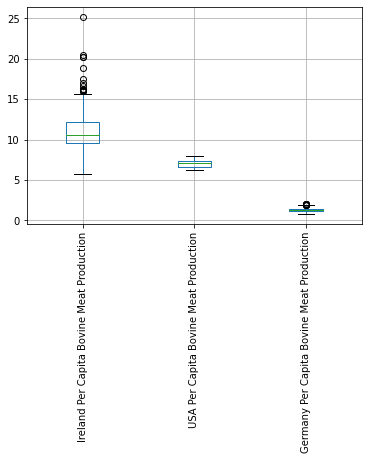

In [51]:
bovineMeatData.boxplot(rot=90);

## Trade

In [52]:
allTrade = pd.concat([irelandTrade, germanyTrade, usaTrade], axis=1)
allTrade

Element,Export Quantity,Import Quantity,Ireland Surplus,Germany Surplus,USA Surplus
Year,,,,,
1992-01-01,71485.0000,6630.0000,64855.0000,359471.0000,18592.0000
1992-02-01,72090.0833,6511.4167,65578.6667,351320.4167,15481.0000
1992-03-01,72695.1667,6392.8333,66302.3333,343169.8333,12370.0000
1992-04-01,73300.2500,6274.2500,67026.0000,335019.2500,9259.0000
1992-05-01,73905.3333,6155.6667,67749.6667,326868.6667,6148.0000
...,...,...,...,...,...
2019-09-01,35891.0000,6803.6667,29087.3333,15932.6667,1814.6667
2019-10-01,35510.7500,6883.5000,28627.2500,15173.5000,233.2500
2019-11-01,35130.5000,6963.3333,28167.1667,14414.3333,-1348.1667


In [53]:
fig = px.line(allTrade,
             labels={'value': 'Percentage Growth',
                    'Month':'Date'})

fig.show()

In [54]:
fig = px.line(allTrade.pct_change().cumsum(),
             labels={'value': 'Percentage Growth',
                    'Month':'Date'})

fig.show()

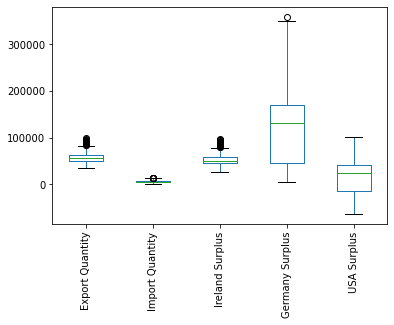

In [55]:
allTrade.plot(kind='box', rot=90);

## Land Productivity Per Meat Annual Data

In [56]:
beefProduction = pd.concat([irelandLand, germanyLand, usaLand], axis=1)

fig = px.line(beefProduction.pct_change().cumsum())

fig.show()

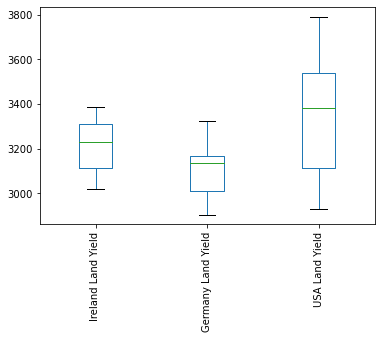

In [57]:
beefProduction.plot(kind='box', rot=90);

## For Machine Learning Model

### Ireland

In [58]:
irelandAllData = pd.concat([irelandGDP, irelandLand, irelandPop, 
                            irelandTrade, prices, irelandData], axis=1).dropna()
irelandAllData

,Ireland GDP,Ireland GDP Per Capita,Ireland Land Yield,Ireland Population,Export Quantity,Import Quantity,Ireland Surplus,Price,Ireland Bovine Meat,Ireland Pig Meat,Ireland Lamb Meat
1992-01-01,76486482000.0000,11727.6453,3309.0000,3558430.0000,71485.0000,6630.0000,64855.0000,251.5011,35.0000,17.9000,6.5000
1992-02-01,76658105500.0000,11800.6422,3308.5000,3559915.9167,72090.0833,6511.4167,65578.6667,246.5035,31.9000,15.0000,5.3000
1992-03-01,76829729000.0000,11873.6390,3308.0000,3561401.8333,72695.1667,6392.8333,66302.3333,241.5060,46.7000,16.5000,4.7000
1992-04-01,77001352500.0000,11946.6358,3307.5000,3562887.7500,73300.2500,6274.2500,67026.0000,236.5084,40.0000,16.0000,5.9000
1992-05-01,77172976000.0000,12019.6326,3307.0000,3564373.6667,73905.3333,6155.6667,67749.6667,238.0293,33.8000,15.9000,7.9000
...,...,...,...,...,...,...,...,...,...,...,...
2019-09-01,347254666666.6667,73943.3529,3359.3333,4974596.0000,35891.0000,6803.6667,29087.3333,504.1021,32.9700,24.4600,5.2800
2019-10-01,348888500000.0000,74154.5104,3361.0000,4979628.0000,35510.7500,6883.5000,28627.2500,530.3635,61.8200,26.2000,6.6900
2019-11-01,350522333333.3333,74365.6678,3362.6667,4984660.0000,35130.5000,6963.3333,28167.1667,503.4316,59.8900,26.2900,6.1200
2019-12-01,352156166666.6667,74576.8253,3364.3333,4989692.0000,34750.2500,7043.1667,27707.0833,476.4998,48.2500,23.6800,5.8100


In [59]:
#ProfileReport(irelandAllData)

### Germany

In [60]:
germanyAllData = pd.concat([germanyGDP, germanyLand, germanyPop, 
                            germanyTrade, prices, germanData], axis=1).dropna()
germanyAllData

,Germany GDP,Germany GDP Per Capita,Germany Land Yield,German Population,Germany Surplus,Price,Germany Bovine Meat,Germany Pig Meat,Germany Lamb Meat
1992-01-01,2261460000000.0000,21110.9270,2905.0000,80624598.0000,359471.0000,251.5011,159.1700,323.2400,2.9100
1992-02-01,2259619166666.6665,21149.5396,2908.5833,80668911.7500,351320.4167,246.5035,140.1100,285.4000,2.5200
1992-03-01,2257778333333.3335,21188.1523,2912.1667,80713225.5000,343169.8333,241.5060,164.5400,316.9800,3.1600
1992-04-01,2255937500000.0000,21226.7649,2915.7500,80757539.2500,335019.2500,236.5084,155.6100,297.4600,3.6500
1992-05-01,2254096666666.6665,21265.3776,2919.3333,80801853.0000,326868.6667,238.0293,144.8200,300.1500,2.7000
...,...,...,...,...,...,...,...,...,...
2019-09-01,3146116666666.6665,40929.9411,3301.0000,83191337.3333,15932.6667,504.1021,93.0000,440.0000,2.0000
2019-10-01,3133760000000.0000,40821.0871,3307.0000,83203634.2500,15173.5000,530.3635,103.0000,468.0000,2.0000
2019-11-01,3121403333333.3335,40712.2332,3313.0000,83215931.1667,14414.3333,503.4316,111.0000,460.0000,2.0000
2019-12-01,3109046666666.6665,40603.3793,3319.0000,83228228.0833,13655.1667,476.4998,89.0000,414.0000,2.0000


In [61]:
#ProfileReport(germanyAllData)

### USA

In [62]:
usaAllData = pd.concat([usaGDP, usaLand, usaPop, 
                            usaTrade, prices, usaData], axis=1).dropna()
usaAllData

,USA GDP,USA GDP Per Capita,USA Land Yield,USA Population,USA Surplus,Price,USA Bovine Meat,USA Pig Meat,USA Sheep Meat
1992-01-01,10139200000000.0000,25418.9908,3014.0000,256514000.0000,18592.0000,251.5011,2030.4591,403.4463,143.3006
1992-02-01,10162450000000.0000,25499.6827,3014.0000,256797750.0000,15481.0000,246.5035,2048.0961,401.2416,143.3006
1992-03-01,10185700000000.0000,25580.3746,3014.0000,257081500.0000,12370.0000,241.5060,2043.6868,399.0370,145.5052
1992-04-01,10208950000000.0000,25661.0665,3014.0000,257365250.0000,9259.0000,236.5084,2045.8915,401.2416,141.0960
1992-05-01,10232200000000.0000,25741.7584,3014.0000,257649000.0000,6148.0000,238.0293,2059.1192,403.4463,143.3006
...,...,...,...,...,...,...,...,...,...
2019-09-01,19521166666666.6680,63897.5237,3670.6667,329099399.6667,1814.6667,504.1021,2083.3701,462.9711,138.8913
2019-10-01,19464500000000.0000,63724.7731,3679.0000,329195580.5000,233.2500,530.3635,2094.3932,467.3804,141.0960
2019-11-01,19407833333333.3320,63552.0224,3687.3333,329291761.3333,-1348.1667,503.4316,2120.8487,473.9943,141.0960
2019-12-01,19351166666666.6680,63379.2717,3695.6667,329387942.1667,-2929.5833,476.4998,2112.0302,473.9943,138.8913


In [63]:
#ProfileReport(usaAllData)

# Statistics

https://www.statology.org/python-guides/
https://pingouin-stats.org/api.html


In [64]:
#import matplotlib.pyplot as plt
#from statsmodels.formula.api import ols
#from scipy import stats
import pingouin as pg

## QQ Plots

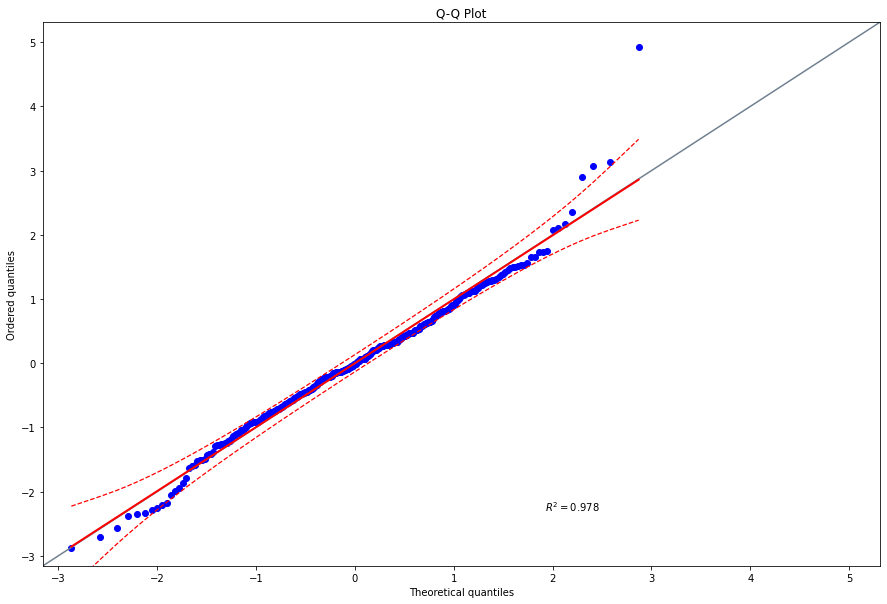

<Figure size 432x288 with 0 Axes>

In [65]:
#Normality plot. Our variable is "charges"
ax = pg.qqplot(irelandAllData['Ireland Bovine Meat'], figsize=(15,10))
plt.figure();

In [66]:
irelandAllData.describe()

,Ireland GDP,Ireland GDP Per Capita,Ireland Land Yield,Ireland Population,Export Quantity,Import Quantity,Ireland Surplus,Price,Ireland Bovine Meat,Ireland Pig Meat,Ireland Lamb Meat
count,337.0000,337.0000,337.0000,337.0000,337.0000,337.0000,337.0000,337.0000,337.0000,337.0000,337.0000
mean,183252997913.9466,37539.1028,3214.9184,4230366.2819,58341.3694,6073.7641,52267.6053,293.9649,46.3696,19.5099,5.8798
std,71261498532.1322,16453.9733,112.2077,464416.0490,11742.4748,2676.7195,12830.7570,102.0288,8.8794,3.0352,1.7486
min,76486482000.0000,11727.6453,3018.0000,3558430.0000,34370.0000,97.0000,27247.0000,166.2159,20.8000,14.1000,2.0000
25%,130485000000.0000,24712.6007,3112.3333,3754786.0000,50600.1667,4485.0000,44733.0000,201.5807,41.0200,17.2000,4.6000
50%,187426333333.3333,37709.4495,3230.0000,4273591.0000,56908.9167,6093.0000,50424.0000,260.0355,46.2900,18.7000,5.6000
75%,202103000000.0000,43651.9599,3309.2500,4623816.0000,63288.0000,7778.2500,58111.0000,399.7680,51.5000,21.6200,6.9000
max,353790000000.0000,74787.9827,3388.0000,4994724.0000,98538.0000,13568.0000,96894.0000,564.3998,90.0000,29.7000,10.3000


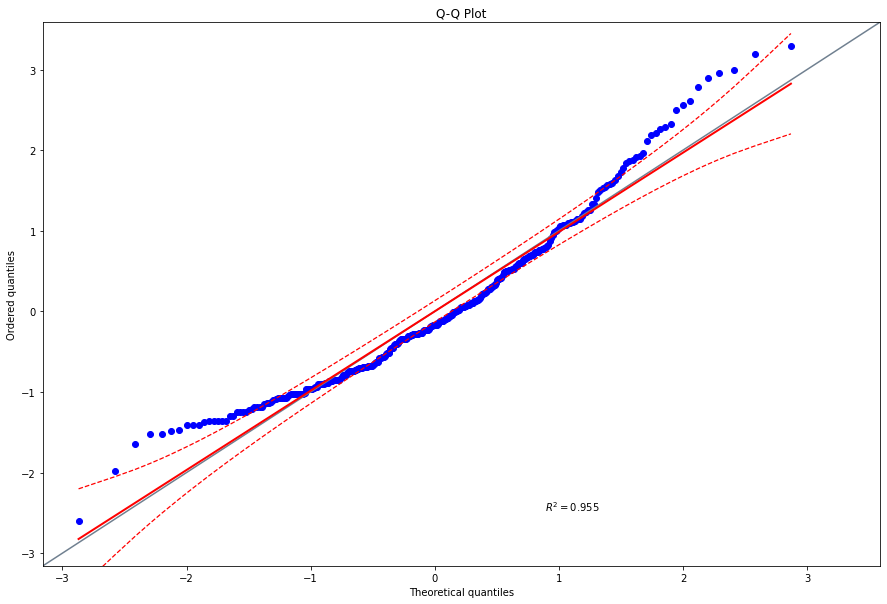

<Figure size 432x288 with 0 Axes>

In [67]:
#Normality plot. Our variable is "charges"
ax = pg.qqplot(germanyAllData['Germany Bovine Meat'], figsize=(15,10))
plt.figure();

In [68]:
germanyAllData.describe()

,Germany GDP,Germany GDP Per Capita,Germany Land Yield,German Population,Germany Surplus,Price,Germany Bovine Meat,Germany Pig Meat,Germany Lamb Meat
count,337.0000,337.0000,337.0000,337.0000,337.0000,337.0000,337.0000,337.0000,337.0000
mean,2714755771513.3530,30109.7528,3096.8754,81940129.0312,122119.3635,293.9649,106.0945,386.0739,2.9109
std,291356466367.3461,6046.2145,100.5342,723563.6261,73854.0014,102.0288,17.7787,65.7352,1.3047
min,2239370000000.0000,21110.9270,2905.0000,80274983.0000,5268.0000,166.2159,59.9300,265.0700,1.0000
25%,2483280000000.0000,25084.9440,3012.0000,81526605.5000,46622.3333,201.5807,93.0000,324.0400,2.0000
50%,2691383333333.3335,28953.4202,3135.0000,82075465.3333,131788.5000,260.0355,103.0000,383.4100,2.6900
75%,2917240000000.0000,34860.5482,3166.4167,82453926.8333,169628.8333,399.7680,116.4300,446.0000,3.5900
max,3244970000000.0000,41800.7725,3325.0000,83240525.0000,359471.0000,564.3998,164.5400,504.0000,7.7300


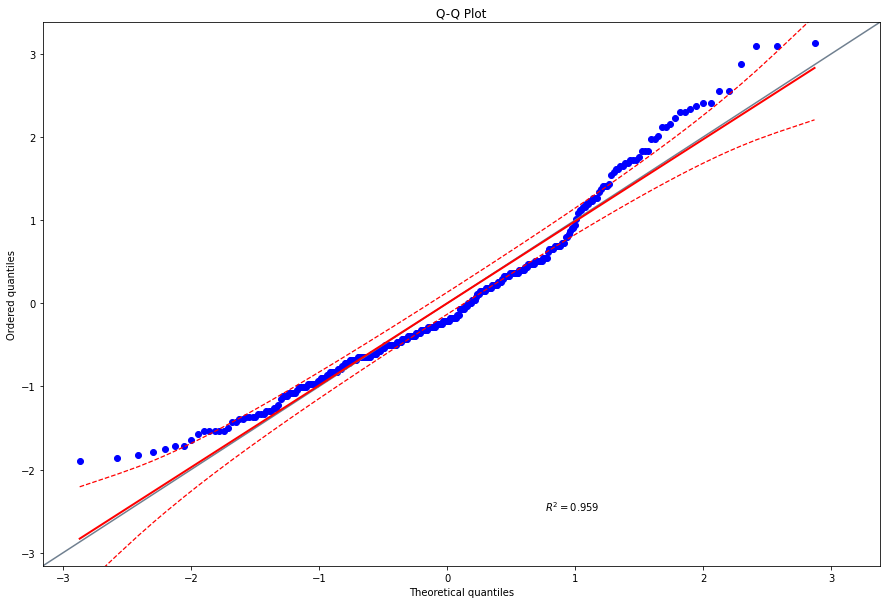

<Figure size 432x288 with 0 Axes>

In [69]:
#Normality plot. Our variable is "charges"
ax = pg.qqplot(usaAllData['USA Bovine Meat'], figsize=(15,10))
plt.figure();

In [70]:
usaAllData.describe()

,USA GDP,USA GDP Per Capita,USA Land Yield,USA Population,USA Surplus,Price,USA Bovine Meat,USA Pig Meat,USA Sheep Meat
count,337.0000,337.0000,337.0000,337.0000,337.0000,337.0000,337.0000,337.0000,337.0000
mean,15289187685459.9414,44424.6492,3351.5579,296997587.3220,14704.7433,293.9649,2083.1346,439.5903,149.6201
std,2784128131668.9365,11526.1355,245.1709,21612764.1152,36284.5119,102.0288,61.4634,22.0503,7.4578
min,10139200000000.0000,25418.9908,2929.0000,256514000.0000,-64484.0000,166.2159,1966.5250,396.8324,130.0728
25%,13193600000000.0000,34513.5615,3112.2500,279040000.0000,-14452.3333,201.5807,2043.6868,421.0833,143.3006
50%,15946616666666.6660,46298.7314,3383.0000,298379912.0000,25188.6667,260.0355,2070.1423,440.9249,149.9145
75%,17258200000000.0000,53106.5368,3539.0000,316059947.0000,41027.5000,399.7680,2112.0302,458.5619,154.3237
max,19974500000000.0000,65279.5290,3791.0000,329484123.0000,102163.0000,564.3998,2275.1724,476.1989,174.1653


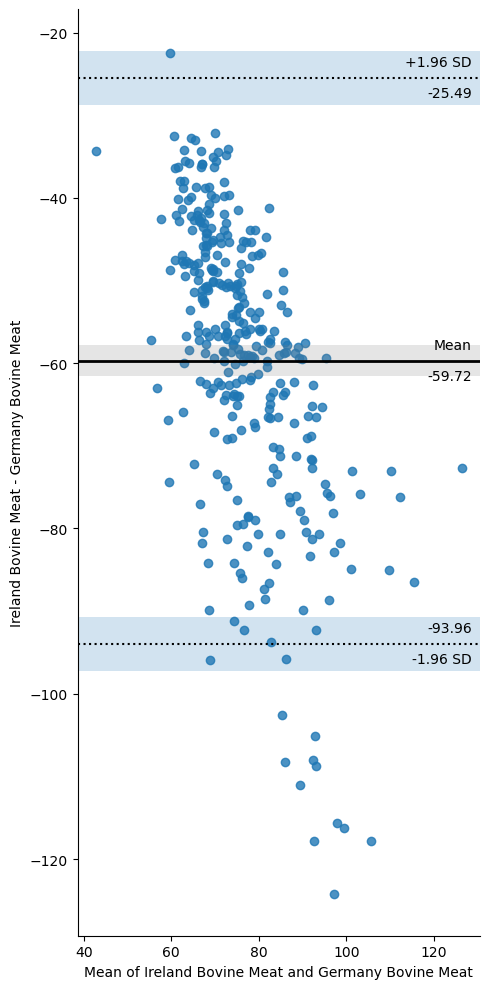

In [71]:
#https://pingouin-stats.org/generated/pingouin.plot_blandaltman.html#pingouin.plot_blandaltman
ax = pg.plot_blandaltman(irelandAllData['Ireland Bovine Meat'], germanyAllData['Germany Bovine Meat'], figsize=(5,10))
plt.tight_layout();

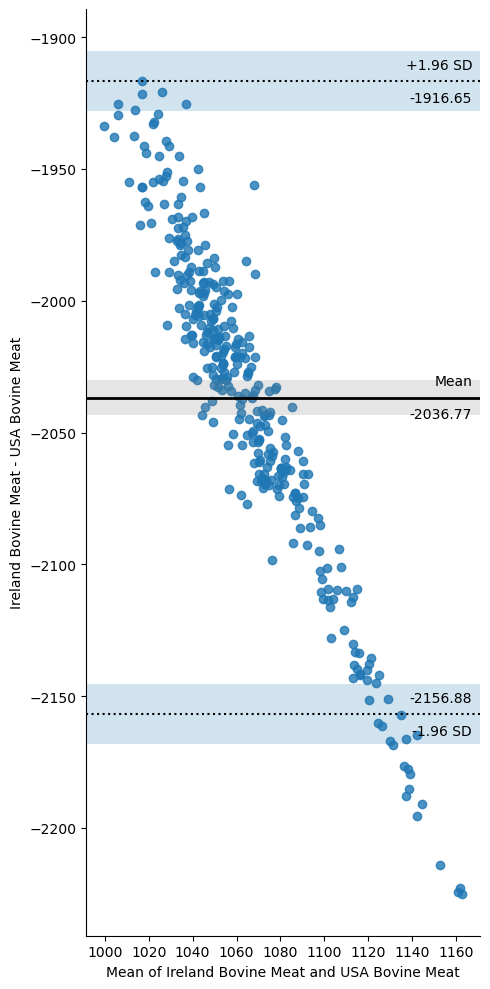

In [72]:
ax = pg.plot_blandaltman(irelandAllData['Ireland Bovine Meat'], usaAllData['USA Bovine Meat'], figsize=(5,10))
plt.tight_layout();

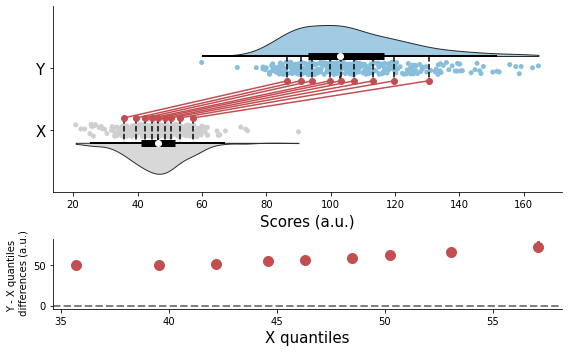

In [73]:
# Plot shift
#https://pingouin-stats.org/generated/pingouin.plot_shift.html#pingouin.plot_shift
fig = pg.plot_shift(irelandAllData['Ireland Bovine Meat'], germanyAllData['Germany Bovine Meat'])

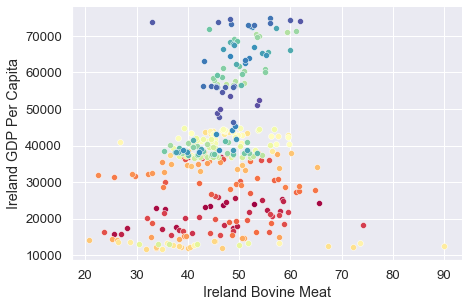

In [74]:
sns.set(style='darkgrid', font_scale=1.2)

g = pg.plot_rm_corr(data=irelandAllData, x='Ireland Bovine Meat', y='Ireland GDP Per Capita',
                    subject='Price', legend=False,
                    kwargs_facetgrid=dict(height=4.5, aspect=1.5,
                                          palette='Spectral'))

## Shapiro Wilk Test

In [75]:
beef = allData.filter(items=allData.columns[allData.columns.str.contains("Bovine",regex=True)])
beef.columns = ['Ireland', 'USA', 'Germany']

In [140]:
fn.Stats.distribution(beef[['Ireland','USA']])

Ireland not normal distribution, pvalue = 0.000102
USA not normal distribution, pvalue = 0.000001


MannwhitneyuResult(statistic=0.0, pvalue=2.86726940200673e-120)

In [77]:
fn.Stats.distribution(irelandAllData[['Export Quantity', 'Import Quantity','Price', 'Ireland Bovine Meat']])

Export Quantity not normal distribution, pvalue = 0.000000
Import Quantity not normal distribution, pvalue = 0.000061
Price not normal distribution, pvalue = 0.000000
Ireland Bovine Meat not normal distribution, pvalue = 0.000159


KruskalResult(statistic=3.0, pvalue=0.3916251762710877)

In [78]:
fn.Stats.distribution(germanyAllData[['Price', 'Germany Bovine Meat']])

Price not normal distribution, pvalue = 0.000000
Germany Bovine Meat not normal distribution, pvalue = 0.000000


MannwhitneyuResult(statistic=113569.0, pvalue=8.818297124822933e-112)

In [79]:
fn.Stats.distribution(usaAllData[['Price', 'USA Bovine Meat']])

Price not normal distribution, pvalue = 0.000000
USA Bovine Meat not normal distribution, pvalue = 0.000000


MannwhitneyuResult(statistic=0.0, pvalue=8.756635956537041e-112)

# Data PreProcessing

In [80]:
data = fn.dataProcessing(irelandAllData.copy(), 'Ireland Bovine Meat', 12)
data.targetIntoLast()
data.addMonth()
data.highLow()
data.movingAverage()
data.removeOutliers()
data.data

,Month,Ireland GDP,Ireland GDP Per Capita,Ireland Land Yield,Ireland Population,Export Quantity,Import Quantity,Ireland Surplus,Price,Ireland Pig Meat,High,Low,MovingAverage,Ireland Lamb Meat,Ireland Bovine Meat
1992-01-01,1,76486482000.0000,11727.6453,3309.0000,3558430.0000,71485.0000,6630.0000,64855.0000,251.5011,17.9000,NaN,NaN,NaN,6.5000,35.0000
1992-02-01,2,76658105500.0000,11800.6422,3308.5000,3559915.9167,72090.0833,6511.4167,65578.6667,246.5035,15.0000,NaN,NaN,NaN,5.3000,31.9000
1992-03-01,3,76829729000.0000,11873.6390,3308.0000,3561401.8333,72695.1667,6392.8333,66302.3333,241.5060,16.5000,NaN,NaN,NaN,4.7000,46.7000
1992-04-01,4,77001352500.0000,11946.6358,3307.5000,3562887.7500,73300.2500,6274.2500,67026.0000,236.5084,16.0000,NaN,NaN,NaN,5.9000,40.0000
1992-05-01,5,77172976000.0000,12019.6326,3307.0000,3564373.6667,73905.3333,6155.6667,67749.6667,238.0293,15.9000,NaN,NaN,NaN,7.9000,33.8000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-01,9,347254666666.6667,73943.3529,3359.3333,4974596.0000,35891.0000,6803.6667,29087.3333,504.1021,24.4600,61.0300,32.9700,51.1850,5.2800,32.9700
2019-10-01,10,348888500000.0000,74154.5104,3361.0000,4979628.0000,35510.7500,6883.5000,28627.2500,530.3635,26.2000,61.8200,32.9700,51.3950,6.6900,61.8200
2019-11-01,11,350522333333.3333,74365.6678,3362.6667,4984660.0000,35130.5000,6963.3333,28167.1667,503.4316,26.2900,61.8200,32.9700,51.3000,6.1200,59.8900
2019-12-01,12,352156166666.6667,74576.8253,3364.3333,4989692.0000,34750.2500,7043.1667,27707.0833,476.4998,23.6800,61.8200,32.9700,51.6508,5.8100,48.2500


<AxesSubplot:>

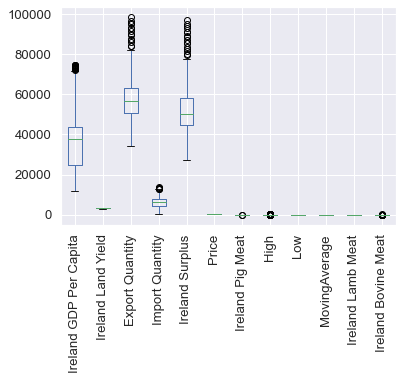

In [81]:
data.data.drop(columns=['Ireland GDP', 'Ireland Population']).plot(kind='box', rot=90)

<AxesSubplot:>

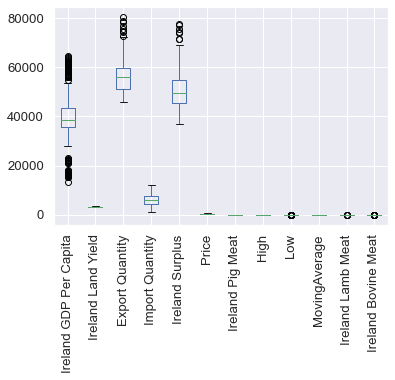

In [82]:
data.dataNoOutliers.drop(columns=['Ireland GDP', 'Ireland Population']).plot(kind='box', rot=90)

# Machine Learning Models

## Import Regression Models

In [83]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import BayesianRidge
from xgboost import XGBRegressor
from sklearn.svm import SVR

## SKLearn Libraries

In [84]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from collections import Counter

In [107]:
regressors = {'PolynomialFeatures': PolynomialFeatures,
              'SVR': SVR, 'Bayesian': BayesianRidge, 
              'XGBRegressor': XGBRegressor}

parameters = {'SVR': {'gridParams':
                    {'svr__C': [1, 10, 100, 1000],
                    'svr__gamma': [0.1, 0.001, 0.0001]}},
              'Bayesian': {'gridParams': 
                        {'bayesianridge__alpha_init':[1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.9],
                          'bayesianridge__lambda_init': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-9],
                         'bayesianridge__normalize': [True, False],
                         'bayesianridge__n_iter': [300, 400, 500, 1000]}},
             'XGBRegressor': {'gridParams': 
                    {'xgbregressor__max_depth': [2, 4, 6],
                    'xgbregressor__n_estimators': [50, 100, 200, 400, 500, 1000],
                    'xgbregressor__gamma': [0.01, 0.1, 1.0],
                    'xgbregressor__learning_rate': [0.001, 0.01, 0.1]}}, 
             'PolynomialFeatures': {'gridParams': 
                         {'Bayesian': {'polynomialfeatures__degree': [1, 2, 3],
                                       'polynomialfeatures__interaction_only': [True, False],
                                       'polynomialfeatures__interaction_bias': [True, False],
                                    'bayesianridge__alpha_init':[1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.9],
                                      'bayesianridge__lambda_init': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-9],
                                     'bayesianridge__normalize': [True, False],
                                     'bayesianridge__n_iter': [300, 400, 500, 1000]}}}}

addEstimators = {'PCA': PCA(n_components=0.95), 'KMeans': KMeans(n_clusters=5),'None': None}

scalers = {'Standard Scaler': StandardScaler(),
          'Min Max Scaler': MinMaxScaler(),
          'Robust Scaler': RobustScaler()}

In [122]:
X, y = data.data.iloc[:, :-1], data.data.iloc[:, -1]

num_cols = X.select_dtypes(exclude=['object']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

sca = RobustScaler()
imputer = KNNImputer(n_neighbors=3)
encoder = OneHotEncoder(handle_unknown='ignore').fit(X[cat_cols])

X_transformed = pd.DataFrame(data=imputer.fit_transform(X[num_cols]), columns=num_cols)
X_transformed = pd.DataFrame(data=sca.fit_transform(X_transformed[num_cols]), columns=num_cols)
X_encoded = pd.DataFrame(data=encoder.transform(X[cat_cols]).toarray(), columns=encoder.get_feature_names())

X_transformed = pd.concat([X_transformed, X_encoded], axis=1)

In [ ]:
pca = PCA(n_components=0.95).fit(X_transformed)
pca_transformed = pca.fit_transform(X_transformed)

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [ ]:
n_compenents = len(pca.explained_variance_ratio_)
n_compenents

In [ ]:
kMeans_inertia = pd.DataFrame(data=[],index=range(2,21), columns=['inertia'])
for n_clusters in range(2,21):
    kmeans = KMeans(n_clusters=n_clusters)
    cutoff = 99
    kmeans.fit(pca_transformed[:,0:cutoff])
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_

In [ ]:
kmeans_per_k = [KMeans(n_clusters=k).fit(pca_transformed)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(5, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
silhouette_scores = [silhouette_score(pca_transformed, model.labels_)
                     for model in kmeans_per_k[1:]]

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

In [ ]:
#max(silhouette_scores)

## Regression Models

### Run Models with Outliers

In [119]:
regressors = {'PolynomialFeatures': PolynomialFeatures,
              'SVR': SVR, 'Bayesian': BayesianRidge, 
              'XGBRegressor': XGBRegressor}

parameters = {'SVR': {'gridParams':
                    {'svr__C': [1, 10, 100, 1000],
                    'svr__gamma': [0.1, 0.001, 0.0001]}},
              'Bayesian': {'gridParams': 
                        {'bayesianridge__alpha_init':[1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.9],
                          'bayesianridge__lambda_init': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-9],
                         'bayesianridge__normalize': [True, False],
                         'bayesianridge__n_iter': [300, 400, 500, 1000]}},
             'XGBRegressor': {'gridParams': 
                    {'xgbregressor__max_depth': [2, 4, 6],
                    'xgbregressor__n_estimators': [50, 100, 200, 400, 500, 1000],
                    'xgbregressor__gamma': [0.01, 0.1, 1.0],
                    'xgbregressor__learning_rate': [0.001, 0.01, 0.1]}}, 
             'PolynomialFeatures': {'gridParams': 
                                    {'polynomialfeatures__degree': [1, 2, 3],
                                       'polynomialfeatures__interaction_only': [True, False],
                                       'polynomialfeatures__interaction_bias': [True, False],
                                      'bayesianridge__alpha_init':[1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.9],
                                      'bayesianridge__lambda_init': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-9],
                                     'bayesianridge__normalize': [True, False],
                                     'bayesianridge__n_iter': [300, 400, 500, 1000]}}}

addEstimators = {'PCA': PCA(n_components=0.95), 'KMeans': KMeans(n_clusters=5),'None': None}

scalers = {'Standard Scaler': StandardScaler(),
          'Min Max Scaler': MinMaxScaler(),
          'Robust Scaler': RobustScaler()}

In [120]:
class Models():
    def runModels(self, regressors, parameters, addEstimators, scalers, X, y, outliers):
        results = pd.DataFrame(columns=['Model Name', 'Scaler', 'Outliers',
                                        'Dimension Reducer', 'Best Parameters', 'R2 Score',
                                       'Mean Square Error', 'Mean Absolute Error',
                                       'Feature Importance'])
        count = 1
        total = len(regressors) * len(addEstimators) * len(scalers)
        # https://lifewithdata.com/2022/03/09/onehotencoder-how-to-do-one-hot-encoding-in-sklearn/
        # get the categorical and numeric column names
        num_cols = X.select_dtypes(exclude=['object']).columns.tolist()
        cat_cols = X.select_dtypes(include=['object']).columns.tolist()

        for h, i in addEstimators.items():
            for l, m in scalers.items():
                # Create num columns for pipeline.
                num_pipe = make_pipeline(KNNImputer(n_neighbors=3), m)
                for j, k in regressors.items():
                    feature_importance = 'Not Available'
                    dimensionReduction = 'Not Available'
                    if j != 'PolynomialFeatures':
                        pipe = make_pipeline(ColumnTransformer([('cat', 
                                    OneHotEncoder(handle_unknown='ignore'), cat_cols),
                                    ('num', num_pipe, num_cols)]), i, k())

                        grid = GridSearchCV(pipe, param_grid=parameters[j]['gridParams'], cv=5)
                        grid.fit(X, y)
                        if j == 'RandomForestRegressor':
                            feature_importance = grid.best_estimator_.named_steps['randomforestregressor'].feature_importances_.astype('object')
                        if h == 'PCA':
                            dimensionReduction = grid.best_estimator_.named_steps['pca'].components_
                        if h == 'KMeans':
                            dimensionReduction = Counter(grid.best_estimator_.named_steps['kmeans'].labels_)
                        results = results.append({'Model Name':  j,'Scaler': l,
                                        'Outliers' : outliers, 'Dimension Reducer': h, 'Dimension Reduction': dimensionReduction,
                                       'Best Parameters': str(grid.best_params_),
                                       'R2 Score': grid.score(X,y), 'Mean Square Error':
                                       mean_squared_error(y, grid.predict(X)), 
                            'Mean Absolute Error': mean_absolute_error(y, grid.predict(X)),
                                                  'Feature Importance': feature_importance}, 
                                                 ignore_index=True)
                    elif j == 'PolynomialFeatures':
                        pipe = make_pipeline(ColumnTransformer([('cat', 
                                OneHotEncoder(handle_unknown='ignore'), cat_cols),
                                ('num', num_pipe, num_cols)]), i, k(), BayesianRidge())
                        # Add parameters unique to 
                        grid = GridSearchCV(pipe, 
                            param_grid=parameters[j]['gridParams']['Bayesian'], cv=5)
                        grid.fit(X, y)
                        if h == 'PCA':
                            dimensionReduction = grid.best_estimator_.named_steps['pca'].components_
                        if h == 'KMeans':
                            dimensionReduction = Counter(grid.best_estimator_.named_steps['kmeans'].labels_)
                        results = results.append({'Model Name':  'Polynomial Features Bayesian','Scaler': l,
                                        'Outliers' : outliers, 'Dimension Reducer': h, 'Dimension Reduction': dimensionReduction,
                                       'Best Parameters': str(grid.best_params_),
                                       'R2 Score': grid.score(X,y), 'Mean Square Error':
                                       mean_squared_error(y, grid.predict(X)), 
                            'Mean Absolute Error': mean_absolute_error(y, grid.predict(X)),
                                                  'Feature Importance': feature_importance}, 
                                                 ignore_index=True)
                    print('Model {}'.format(j))
                    print('Result for this model is {:2f} % '.format(grid.score(X,y)))
                    print('Completed {}% \n'.format(round((count / total)*100,2)))
                    count += 1
        return results

In [121]:
X, y = data.data.iloc[:, :-1], data.data.iloc[:, -1]
resultsOutliers = Models().runModels(regressors, parameters, addEstimators, scalers, X, y, 'Outliers')

ValueError: Invalid parameter interaction_bias for estimator PolynomialFeatures(degree=1). Check the list of available parameters with `estimator.get_params().keys()`.

### Run Models Without Outliers

In [ ]:
X, y = data.dataNoOutliers.iloc[:, :-1], data.dataNoOutliers.iloc[:, -1]
resultsNoOutliers = fn.Models().runModels(regressors, parameters, addEstimators, scalers, X, y, 'No Outliers')

## All Model Results

In [ ]:
outResults = pd.DataFrame(resultsOutliers)
noOutResults = pd.DataFrame(resultsNoOutliers)
allResults = pd.concat([outResults, noOutResults], axis=0)
allResults.sort_values(by='R2 Score', ascending=False, inplace=True)
allResults.reset_index(inplace=True, drop=True)
allResults.head(25)

In [ ]:
#noOutResults.sort_values(by='R2 Score: ', ascending=False)

In [ ]:
allResults.to_csv('otherSpreadsheets/ModelResults18052022.csv', index=False)

In [ ]:
#allResults[['Model Name: ', 'R2 Score: ']].pivot_table(columns=['Model Name: '])

In [ ]:
#allResults[['Model Name: ', 'R2 Score: ']].groupby('Model Name: ')

In [ ]:
allResults[['Model Name', 'R2 Score']].groupby(by='Model Name').mean().sort_values('R2 Score', ascending=False).plot(kind='bar');

In [ ]:
allResults[['Scaler', 'R2 Score']].groupby(by='Scaler').mean().sort_values('R2 Score', ascending=False).plot(kind='bar');

In [ ]:
allResults[['Outliers', 'R2 Score']].groupby(by='Outliers').mean().sort_values('R2 Score', ascending=False).plot(kind='bar');

In [ ]:
allResults[['Dimension Reducer', 'R2 Score']].groupby(by='Dimension Reducer').mean().sort_values('R2 Score', ascending=False).plot(kind='bar');

In [ ]:
allResults =pd.read_csv('otherSpreadsheets/ModelResults17052022.csv')
allResults

In [ ]:
from sklearn.linear_model import BayesianRidge, ARDRegression, ElasticNetCV

In [ ]:
reg = BayesianRidge(tol=1e-6, fit_intercept=False, compute_score=True).fit(X_transformed, y)

In [ ]:
reg.score(X_transformed, y)

In [ ]:
ard = ARDRegression().fit(X_transformed,y)
ard.score(X_transformed, y)

In [ ]:
from sklearn.linear_model import BayesianRidge, ARDRegression, ElasticNetCV
bay_params = {'alpha_init':[1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.9],
              'alpha_1':[1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.9],
              'lambda_init': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-9],
              'lambda_1': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-9],
             'normalize': [True, False],
             'n_iter': [300, 400, 500, 1000]}
a = GridSearchCV(estimator=BayesianRidge(), param_grid = bay_params, cv = 3, n_jobs=-1)
a.fit(X_transformed, y)
a.score(X_transformed, y)

In [ ]:
elesNet = ElasticNetCV(normalize=True, random_state=0).fit(X_transformed, y)
elesNet.score(X_transformed, y)

In [ ]:
allResults.head(2).T

In [ ]:
allResults.loc[1,'Best Parameters']

In [ ]:
allResults.loc[0, 'Best Parameters']

In [ ]:
X, y = data.data.iloc[:, :-1], data.data.iloc[:, -1]

num_cols = X.select_dtypes(exclude=['object']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# Create num columns for pipeline.
num_pipe = make_pipeline(KNNImputer(n_neighbors=3), MinMaxScaler())

pipe = make_pipeline(ColumnTransformer([('cat', 
            OneHotEncoder(handle_unknown='ignore'), cat_cols),
            ('num', num_pipe, num_cols)]), RandomForestRegressor(bootstrap=True, 
                                                                max_depth=50, n_estimators=20))

pipe.fit(X,y)

In [ ]:
pipe.score(X,y)

In [ ]:
randFeats = pipe.named_steps['randomforestregressor'].feature_importances_.astype('object')
colNames = np.concatenate((X.columns.drop('Month'), 
            pipe.named_steps['columntransformer'].named_transformers_['cat'].get_feature_names()),
            axis=0)

rfFeats = pd.DataFrame(data=randFeats, columns=['Importance'], index=colNames)
rfFeats.sort_values(by= 'Importance', inplace=True, ascending=False)

rfFeats.plot(kind='bar')
plt.xlabel("Random Forest Feature Importance");

# Dashboard

In [126]:
from explainerdashboard import RegressionExplainer, ExplainerDashboard, ExplainerHub
from sklearn.ensemble import RandomForestRegressor

In [127]:
X, y = data.data.iloc[:, :-1], data.data.iloc[:, -1]

num_cols = X.select_dtypes(exclude=['object']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

sca = RobustScaler()
imputer = KNNImputer(n_neighbors=3)
encoder = OneHotEncoder(handle_unknown='ignore').fit(X[cat_cols])

X_transformed = pd.DataFrame(data=imputer.fit_transform(X[num_cols]), columns=num_cols)
X_transformed = pd.DataFrame(data=sca.fit_transform(X_transformed[num_cols]), columns=num_cols)
X_encoded = pd.DataFrame(data=encoder.transform(X[cat_cols]).toarray(), columns=encoder.get_feature_names())

X_transformed = pd.concat([X_transformed, X_encoded], axis=1)

rf = RandomForestRegressor(bootstrap=True, max_depth=70, n_estimators=30)

rf.fit(X_transformed,y)

rf.score(X_transformed, y)

0.9344198204124566

In [128]:
xgb = XGBRegressor(gamma=0.1, learning_rate=0.1, max_depth=4, n_estimators=100)
xgb.fit(X_transformed, y)
xgb.score(X_transformed, y)

0.9529984268182286

In [129]:
allResults['Model Name'].unique()

NameError: name 'allResults' is not defined

In [ ]:
allResults[(allResults['Model Name'] != 'XGBRegressor') & (allResults['Model Name'] != 'RandomForestRegressor')]

In [132]:
import os
#explainer = RegressionExplainer(xgb, X_transformed, y)
db1 = ExplainerDashboard(RegressionExplainer(xgb, X_transformed, y), title='XGBoost Regression')
db2 = ExplainerDashboard(RegressionExplainer(rf, X_transformed, y), title='Random Forest Regression')
hub = ExplainerHub([db1, db2], secret_key=os.environ.get('dcb34dca-d334-4aa5-b9d6-9d36efe2fac3'))

#ExplainerDashboard(explainer, mode='external').run(port=8050)
hub.run(port=8050)

Changing class type to XGBRegressionExplainer...
Generating self.shap_explainer = shap.TreeExplainer(model)
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
Generating layout...
Calculating shap values...
Calculating predictions...
Calculating residuals...
Calculating absolute residuals...
Calculating shap interaction values...
Reminder: TreeShap computational complexity is O(TLD^2), where T is the number of trees, L is the maximum number of leaves in any tree and D the maximal depth of any tree. So reducing these will speed up the calculation.
Generating xgboost model dump...
Calculating dependencies...
Calculating importances...
Calculating ShadowDecTree for each individual decision tree...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExpla

Using random SECRET_KEY: 5ce1cef2-421e-4090-81ab-4552b52de20c, please set it on your app.config["SECRET_KEY"]


Reminder, you can set ExplainerDashboard .name and .description in order to control the url path of the dashboard. Now defaulting to name=dashboard1 and default description...
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
Generating layout...
Calculating dependencies...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Reminder, you can set ExplainerDashboard .name and .description in order to control the url path of the dashboard. Now defaulting to name=dashboard2 and default description...
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is runnin

 * Running on all addresses.
 * Running on http://192.168.1.46:8050/ (Press CTRL+C to quit)
192.168.1.46 - - [18/May/2022 22:33:03] "GET / HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22:33:03] "GET /static/jquery-3.5.1.slim.min.js HTTP/1.1" 304 -
192.168.1.46 - - [18/May/2022 22:33:03] "GET /static/bootstrap.min.js HTTP/1.1" 304 -
192.168.1.46 - - [18/May/2022 22:33:03] "GET /static/bootstrap.min.css HTTP/1.1" 304 -
192.168.1.46 - - [18/May/2022 22:33:03] "GET /index/ HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22:33:03] "GET /index/assets/bootstrap.min.css?m=1647363557.60378 HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22:33:04] "GET /index/_dash-component-suites/dash/dcc/dash_core_components.v2_3_0m1647363514.js HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22:33:05] "GET /index/_dash-component-suites/dash/dcc/dash_core_components.v2_3_0m1647363514.js HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22:33:06] "GET /index/_dash-layout HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22

192.168.1.46 - - [18/May/2022 22:33:38] "POST /dashboards/dashboard1/_dash-update-component HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22:33:38] "POST /dashboards/dashboard1/_dash-update-component HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22:33:38] "POST /dashboards/dashboard1/_dash-update-component HTTP/1.1" 204 -
192.168.1.46 - - [18/May/2022 22:33:38] "POST /dashboards/dashboard1/_dash-update-component HTTP/1.1" 204 -
192.168.1.46 - - [18/May/2022 22:33:38] "POST /dashboards/dashboard1/_dash-update-component HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22:33:38] "POST /dashboards/dashboard1/_dash-update-component HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22:33:38] "POST /dashboards/dashboard1/_dash-update-component HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22:33:38] "POST /dashboards/dashboard1/_dash-update-component HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22:33:38] "POST /dashboards/dashboard1/_dash-update-component HTTP/1.1" 200 -
192.168.1.46 - - [18/May/202

192.168.1.46 - - [18/May/2022 22:34:10] "POST /dashboards/dashboard2/_dash-update-component HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22:34:10] "POST /dashboards/dashboard2/_dash-update-component HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22:34:10] "POST /dashboards/dashboard2/_dash-update-component HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22:34:11] "POST /dashboards/dashboard2/_dash-update-component HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22:34:11] "POST /dashboards/dashboard2/_dash-update-component HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22:34:11] "POST /dashboards/dashboard2/_dash-update-component HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22:34:11] "POST /dashboards/dashboard2/_dash-update-component HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22:34:11] "POST /dashboards/dashboard2/_dash-update-component HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22:34:11] "POST /dashboards/dashboard2/_dash-update-component HTTP/1.1" 200 -
192.168.1.46 - - [18/May/202

192.168.1.46 - - [18/May/2022 22:34:26] "POST /dashboards/dashboard2/_dash-update-component HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22:34:26] "POST /dashboards/dashboard2/_dash-update-component HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22:34:26] "POST /dashboards/dashboard2/_dash-update-component HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22:34:26] "POST /dashboards/dashboard2/_dash-update-component HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22:34:26] "POST /dashboards/dashboard2/_dash-update-component HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22:34:26] "POST /dashboards/dashboard2/_dash-update-component HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22:34:26] "POST /dashboards/dashboard2/_dash-update-component HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22:34:26] "POST /dashboards/dashboard2/_dash-update-component HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22:34:26] "POST /dashboards/dashboard2/_dash-update-component HTTP/1.1" 200 -
192.168.1.46 - - [18/May/202

192.168.1.46 - - [18/May/2022 22:34:48] "POST /dashboards/dashboard1/_dash-update-component HTTP/1.1" 204 -
192.168.1.46 - - [18/May/2022 22:34:48] "POST /dashboards/dashboard1/_dash-update-component HTTP/1.1" 204 -
192.168.1.46 - - [18/May/2022 22:34:48] "POST /dashboards/dashboard1/_dash-update-component HTTP/1.1" 204 -
192.168.1.46 - - [18/May/2022 22:34:48] "POST /dashboards/dashboard1/_dash-update-component HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22:34:48] "POST /dashboards/dashboard1/_dash-update-component HTTP/1.1" 204 -
192.168.1.46 - - [18/May/2022 22:34:48] "POST /dashboards/dashboard1/_dash-update-component HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22:34:48] "POST /dashboards/dashboard1/_dash-update-component HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22:34:48] "POST /dashboards/dashboard1/_dash-update-component HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22:34:48] "POST /dashboards/dashboard1/_dash-update-component HTTP/1.1" 200 -
192.168.1.46 - - [18/May/202

192.168.1.46 - - [18/May/2022 22:35:39] "GET /dashboards/dashboard1/_dash-component-suites/dash/dcc/async-dropdown.js HTTP/1.1" 304 -
192.168.1.46 - - [18/May/2022 22:35:39] "GET /dashboards/dashboard1/_dash-component-suites/dash/dcc/async-slider.js HTTP/1.1" 304 -
192.168.1.46 - - [18/May/2022 22:35:39] "POST /dashboards/dashboard1/_dash-update-component HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22:35:39] "POST /dashboards/dashboard1/_dash-update-component HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22:35:39] "POST /dashboards/dashboard1/_dash-update-component HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22:35:39] "POST /dashboards/dashboard1/_dash-update-component HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22:35:39] "POST /dashboards/dashboard1/_dash-update-component HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22:35:39] "POST /dashboards/dashboard1/_dash-update-component HTTP/1.1" 200 -
192.168.1.46 - - [18/May/2022 22:35:39] "POST /dashboards/dashboard1/_dash-update-comp

In [133]:
ExplainerDashboard.terminate(8050)

Trying to shut down dashboard on port 8050...
Something seems to have failed: HTTPConnectionPool(host='localhost', port=8050): Max retries exceeded with url: /_shutdown_e988f458-520b-4b54-b689-e3216ddded7e (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001E81BDF8970>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))


In [136]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor


In [137]:
from dash import Dash, dcc, html, Input, Output
import plotly.graph_objects as go

app = Dash(__name__)

models = {'Suppor Vector Machine': SVR(),
        'Ridge Regression': Ridge(alpha=10.0, normalize=False),
          'Random Forest': RandomForestRegressor(bootstrap=True, max_depth=70, n_estimators=30),
          'K-NN': KNeighborsRegressor(n_neighbors=10, p=2),
         'XGB Boost': XGBRegressor(gamma=0.1, learning_rate=0.1, max_depth=4, n_estimators=100)}

app.layout = html.Div([
    html.H4("Predicting Ireland's Monthly Beef Production"),
    html.P("Select model:"),
    dcc.Dropdown(
        id='dropdown',
        options=["Suppor Vector Machine", "Ridge Regression", "Random Forest", "K-NN", "XGB Boost"],
        value='Random Forest',
        clearable=False),
    dcc.Graph(id="graph"),])

@app.callback(
    Output("graph", "figure"), 
    Input('dropdown', "value"))
def train_and_display(name):
    model = models[name]
    model.fit(X_transformed, y)

    showAmount = len(X) - 120
    y_pred = model.predict(X_transformed[showAmount:])

    fig = go.Figure([
        go.Scatter(x=X.index[showAmount:], y=y[showAmount:], 
                   name='Actual', mode='markers'),
        go.Scatter(x=X.index[showAmount:], y=y_pred, 
                   name='Prediction')])
    return fig

app.run_server(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
